# Streaming Data

In [1]:
%load_ext autoreload

In [2]:
import requests
import numpy as np
import pandas as pd
import gcsfs
import joblib
from google.cloud import storage
import datetime as dt
import matplotlib.pyplot as plt
import dill

In [3]:
def to_readable_datetime(x):
    from datetime import datetime
    return datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')

In [10]:
df = pd.read_csv("gcs://wagon-data-750-btc-sent-fc/input_data/input_data_1.csv",
                 index_col=0,
                 parse_dates=True)

In [12]:
df.tail()

,n-transactions-per-block,difficulty,utxo-count,mvrv,nvt,avg-block-size,n-transactions-excluding-popular,n-unique-addresses,median-confirmation-time,miners-revenue,...,tweets_sent,reddit_crypto_sent,reddit_econ_sent,volume_gross,crypto_pos,crypto_neg,crypto_neu,econ_pos,econ_neg,econ_neu
2021-11-18,2054.611695,2.267415e+13,7.682603e+07,2.437422,2.814664,1.270386,275592.333333,725020.000000,7.297222,5.265043e+07,...,-0.191667,0.129760,0.164820,3.137042e+09,0.145112,0.081628,0.773259,0.130400,0.148810,0.720790
2021-11-19,2078.240876,2.267415e+13,7.692242e+07,2.423386,3.531133,1.275837,262180.666667,678741.666667,7.027778,4.966713e+07,...,0.155357,0.058168,0.069516,2.119749e+09,0.085474,0.135326,0.779201,0.125548,0.184152,0.690301
2021-11-20,2078.240876,2.267415e+13,7.701882e+07,2.409351,4.247603,1.275837,248769.000000,632463.333333,6.758333,4.966713e+07,...,0.466667,0.083604,0.014180,8.896024e+08,0.085734,0.178020,0.736247,0.127368,0.070532,0.802100
2021-11-21,2078.240876,2.267415e+13,7.711521e+07,2.409351,4.247603,1.275837,248769.000000,586185.000000,6.758333,4.966713e+07,...,-0.022500,0.173188,0.206028,7.894335e+08,0.203692,0.095910,0.700399,0.195318,0.055419,0.749263
2021-11-22,2078.240876,2.267415e+13,7.711521e+07,2.409351,4.247603,1.275837,248769.000000,586185.000000,6.758333,4.966713e+07,...,0.235000,0.159344,0.069456,1.823717e+09,0.103129,0.098261,0.798611,0.140787,0.260983,0.598230


# Reddit Streaming

In [ ]:
file_name = "../keys.json"
with open(file_name, "r") as key_file:
    keys = json.load(key_file)

In [ ]:
# note that CLIENT_ID refers to 'personal use script' and SECRET_TOKEN to 'token'
auth = requests.auth.HTTPBasicAuth(keys['REDDIT_SCRIPT'], keys["REDDIT_TOKEN"])

# here we pass our login method (password), username, and password
data = {
    'grant_type': 'password',
    'username': keys['REDDIT_USERNAME'],
    'password': keys['REDDIT_PASSWORD']
}

# setup our header info, which gives reddit a brief description of our app
headers = {'User-Agent': 'MyBot/0.0.1'}

# send our request for an OAuth token
res = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth,
                    data=data,
                    headers=headers)

# convert response to JSON and pull access_token value
TOKEN = res.json()['access_token']

# add authorization to our headers dictionary
headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}

# while the token is valid (~2 hours) we just add headers=headers to our requests
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)

In [ ]:
crypto_url = "https://oauth.reddit.com/r/CryptoCurrency/top/?sort=top&t=day"

In [ ]:
crypto_req = requests.get(crypto_url, headers=headers)

In [ ]:
reddit_crypto_df = pd.DataFrame()
for post in res.json()['data']['children']:
    reddit_crypto_df = reddit_crypto_df.append(
        {
            'date': post["data"]["created_utc"],
            'subreddit': post['data']['subreddit'],
            'title': post['data']['title'],
            'selftext': post['data']['selftext'],
            'upvote_ratio': post['data']['upvote_ratio'],
            'ups': post['data']['ups'],
            'downs': post['data']['downs'],
            'score': post['data']['score']
        },
        ignore_index=True)

In [ ]:
reddit_crypto_df["date"] = reddit_crypto_df["date"].map(to_readable_datetime)

In [ ]:
econ_url = "https://oauth.reddit.com/search?q=economy+OR+recession+OR+inflation+OR+shutdown+OR+infrastructure+OR+market+OR+retirement&restrict_sr=&sort=top&t=day"

In [ ]:
res = requests.get(econ_url, headers=headers)

reddit_df = pd.DataFrame()
for post in res.json()['data']['children']:
    reddit_df = reddit_df.append(
        {
            'date': post["data"]["created_utc"],
            'subreddit': post['data']['subreddit'],
            'title': post['data']['title'],
            'selftext': post['data']['selftext'],
            'upvote_ratio': post['data']['upvote_ratio'],
            'ups': post['data']['ups'],
            'downs': post['data']['downs'],
            'score': post['data']['score']
        },
        ignore_index=True)
reddit_econ_df["date"] = reddit_econ_df["date"]

In [ ]:
reddit_df

In [ ]:
econ_bert = pd.read_csv(
    "gs://wagon-data-750-btc-sent-fc/sent_processed/econ_bert.csv")[[
        "date", "positive", "negative", "neutral"
    ]]

In [ ]:
crypto_bert["compound"]

In [ ]:
econ_bert["compound"] = (econ_bert.positive - econ_bert.negative) / (
    econ_bert.positive + econ_bert.negative)

In [ ]:
econ_bert.columns = ["econ_pos", "econ_neg", "econ_neu", "econ_compound"]

In [ ]:
econ_bert.set_index("date", inplace=True)

In [ ]:
econ_bert.index = pd.to_datetime(econ_bert.index)

In [ ]:
crypto_bert.index = pd.to_datetime(crypto_bert.index)

In [ ]:
df_merge_two.columns

In [ ]:
df_merge_one = pd.merge(df,
                        crypto_bert[["crypto_pos", "crypto_neg",
                                     "crypto_neu"]],
                        how="left",
                        left_index=True,
                        right_index=True)

In [ ]:
df_merge_two = pd.merge(df_merge_one,
                        econ_bert[["econ_pos", "econ_neg", "econ_neu"]],
                        how="left",
                        left_index=True,
                        right_index=True)

In [ ]:
df_merge_two

In [ ]:
crypto_bert.to_csv(
    "gs://wagon-data-750-btc-sent-fc/sent_processed/crypto_bert.csv")

In [ ]:
econ_bert.to_csv(
    "gs://wagon-data-750-btc-sent-fc/sent_processed/econ_bert.csv")

In [ ]:
df_merge_two.to_csv("gs://wagon-750-btc-sent-fc/input_data/input_data_1.csv")

In [ ]:
economy_keywords = [
    "economy", "recession", "inflation", "shutdown", "infrastructure",
    "market", "retirement"
]

In [ ]:
econ_string = "+OR+".join(economy_keywords)

In [ ]:
econ_string

In [ ]:
econ_bert = pd.read_csv(
    "gs://wagon-data-750-btc-sent-fc/sent_processed/econ_bert.csv",
    index_col=0,
    parse_dates=True)

# Twitter collating

In [74]:
storage_client = storage.Client()

# Note: Client.list_blobs requires at least package version 1.17.0.
blobs = storage_client.list_blobs("wagon-data-750-btc-sent-fc",
                                  prefix=f"sent_data/tweet_reccession")
blob_list = [blob.name for blob in blobs]
blob_list.sort()

In [75]:
blob_list

[]

In [ ]:
inflation_bert = pd.DataFrame()
for blob in blob_list:
    temp_df = pd.read_csv(f"gcs://wagon-data-750-btc-sent-fc/{blob}",
                          index_col=0,
                          parse_dates=True)
    inflation_bert = inflation_bert.append(temp_df)

In [ ]:
inflation_bert["date"] = pd.to_datetime(inflation_bert["date"]).dt.date

In [ ]:
inflation_grouped = inflation_bert.groupby("date").mean()

In [ ]:
inflation_grouped.columns = ["inflation_pos", "inflation_neg", "inflation_neu"]

In [ ]:
df_merge_three = pd.merge(df_merge_two,
                          inflation_grouped,
                          how="left",
                          left_index=True,
                          right_index=True)

In [ ]:
df_merge_three.to_csv("gs://wagon-750-btc-sent-fc/input_data/input_data_2.csv")

# Sentiment DF for Website

In [ ]:
sent_df = df_merge_three[[
    "reddit_econ_sent", "reddit_crypto_sent", "tweets_sent"
]]

In [ ]:
inflation_bert["compound"] = (inflation_bert.positive - inflation_bert.negative
                              ) / (inflation_bert.positive +
                                   inflation_bert.negative)

In [ ]:
inflation_grouped = inflation_bert.groupby("date").mean()

In [ ]:
inflation_grouped.columns = [
    "inflation_pos", "inflation_neg", "inflation_neu", "inflation_compound"
]

In [ ]:
inflation_grouped.to_csv(
    "gs://wagon-data-750-btc-sent-fc/sent_processed/inflation_bert.csv")

In [ ]:
sent_df_1 = sent_df.merge(inflation_grouped["inflation_compound"],
                          left_index=True,
                          right_index=True).merge(
                              econ_bert[["econ_compound"]],
                              left_index=True,
                              right_index=True).merge(
                                  crypto_bert[["crypto_compound"]],
                                  left_index=True,
                                  right_index=True)

In [ ]:
sent_df_1.columns

In [ ]:
sent_df_1.drop("reddit_econ_sent", axis=1, inplace=True)
sent_df_1.drop("reddit_crypto_sent", axis=1, inplace=True)

In [ ]:
sent_df_1["econ_compound"] = (sent_df_1["tweets_sent"] +
                              sent_df_1["econ_compound"]) / 2

In [ ]:
sent_df_1.drop("tweets_sent", axis=1, inplace=True)

In [ ]:
sent_df_1.to_csv(
    "gcs://wagon-data-750-btc-sent-fc/website_data/sent_data_1.csv")

In [ ]:
sent_df_1.merge(
    df_merge_two["volume_gross"], left_index=True, right_index=True).to_csv(
        "gcs://wagon-data-750-btc-sent-fc/website_data/chart_data_1.csv")

# Preproc Pipeline

In [5]:
from Main_package.RNN_model.data import clean_features, clean_test_features

2021-12-01 16:30:26.787751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-01 16:30:26.787800: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [50]:
big_df = pd.read_csv(
    "gs://wagon-data-750-btc-sent-fc/input_data/input_data_1.csv",
    index_col=0,
    parse_dates=True)

In [7]:
pipeline = clean_features(big_df)

In [48]:
fake_1 = pd.read_csv("gs://wagon-data-750-btc-sent-fc/input_data/fake_1",
                     index_col=0,
                     parse_dates=True)

In [49]:
clean_test_features(fake_1)

,n-transactions-per-block,difficulty,utxo-count,mvrv,nvt,avg-block-size,n-transactions-excluding-popular,n-unique-addresses,median-confirmation-time,miners-revenue,...,S&P U.S. TIPS 7-10 Year Index (USD),S&P U.S. Treasury Bond 3-5 Year Index,S&P U.S. TIPS 3-5 Year Index (USD),S&P U.S. TIPS 1-3 Year Index (USD),S&P U.S. TIPS 5-7 Year Index (USD),S&P U.S. Treasury Bill 6-9 Month Index,tweets_sent,reddit_crypto_sent,reddit_econ_sent,volume_gross
2021-08-25,-0.360762,0.861678,1.484932,0.663352,-2.406838,0.372842,-0.087721,0.715103,-1.810167,1.380860,...,2.015781,2.045013,1.966391,1.226304,-0.546254,0.923562,1.289873,0.009306,-0.657061,20.612995
2021-08-26,-0.319383,0.877497,1.488754,0.683136,-1.972124,0.195304,-0.376206,0.655029,-1.692510,1.350133,...,2.008967,2.046472,1.962435,1.226304,-0.403878,1.883524,3.509417,0.060181,-0.711166,20.825791
2021-08-27,-0.278358,0.892949,1.491011,0.702777,-1.616306,0.011533,-0.682608,0.257137,-1.579076,1.318399,...,2.067172,2.091647,2.027560,1.226304,-0.403878,-0.618229,0.266756,0.094336,-0.612330,20.563803
2021-08-28,-0.188108,0.908052,1.493268,0.682938,-1.624699,0.265408,-1.009301,-0.177081,-1.469574,1.297372,...,2.074213,2.101350,2.031989,1.226304,1.015435,1.268133,2.943081,0.147695,-0.699410,19.986069
2021-08-29,-0.099520,0.908052,1.495523,0.662954,-1.633128,0.507538,-0.625775,-0.654931,-1.212013,1.275878,...,2.081251,2.111049,2.036416,1.226304,-0.403878,0.545835,2.014416,0.201053,-0.702000,20.331581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-17,0.413307,1.076333,1.555998,0.785842,-3.293221,1.109824,0.416290,1.325137,-0.797349,1.544637,...,2.318785,2.537117,2.182636,1.229455,-0.377992,1.198626,0.174493,0.323869,-0.677891,21.638166
2021-11-18,0.468953,1.076333,1.553682,0.770169,-2.715368,1.132334,0.181801,1.360443,-0.911924,1.491252,...,2.302427,2.531405,2.171933,1.231031,-1.594652,0.764770,1.357496,0.323869,-0.555708,21.866546
2021-11-19,0.523962,1.076333,1.560422,0.754406,-2.269287,1.154748,-0.064390,1.046534,-1.030810,1.434753,...,2.224131,2.442695,2.113888,1.231031,0.561314,-0.276274,0.357381,0.323869,-0.620867,21.474563
2021-11-20,0.523962,1.076333,1.567154,0.738551,-1.905901,1.154748,-0.323510,0.710450,-1.154344,1.434753,...,2.199696,2.425485,2.084196,1.229455,2.495397,0.093599,-0.223311,0.323869,-0.686026,20.606285


# Placeholder prediction array

In [ ]:
url = "https://cloudsentiment-gijujv7fiq-ew.a.run.app/predict"

In [16]:
pred_df = df.interpolate(method='linear',axis=0)
pred_df['volume_gross'] = np.log(pred_df['volume_gross'])

In [49]:
predict_placeholder = df[["volume_gross"]].iloc[-31:]
predict_placeholder.columns = ["volume_actual"]

In [50]:
predict_placeholder.loc[dt.datetime(2021, 11,
                                    23)] = real_volume.loc[dt.datetime(
                                        2021, 11, 23)]["volume_gross"]

In [53]:
predict_placeholder.drop(dt.datetime(2021, 10,23), inplace = True)

In [55]:
predict_placeholder.head(1)

,volume_actual
2021-10-24,1.037417e+09


In [56]:
predict_placeholder.tail(1)

,volume_actual
2021-11-23,1.591829e+09


In [23]:
pred_df.iloc[-90:].to_csv(f"gcs://wagon-data-750-btc-sent-fc/input_data/pred_1")

In [24]:
for i in range(1, 31):
        pred_df.iloc[-(90+i):-i].to_csv(
        f"gcs://wagon-data-750-btc-sent-fc/input_data/pred_{i+1}")  

In [32]:
pd.read_csv("gcs://wagon-data-750-btc-sent-fc/input_data/pred_31")

,Unnamed: 0,n-transactions-per-block,difficulty,utxo-count,mvrv,nvt,avg-block-size,n-transactions-excluding-popular,n-unique-addresses,median-confirmation-time,...,tweets_sent,reddit_crypto_sent,reddit_econ_sent,volume_gross,crypto_pos,crypto_neg,crypto_neu,econ_pos,econ_neg,econ_neu
0,2021-07-26,1293.883255,1.367259e+13,75958009.0,1.857413,9.785607,0.865762,259735.000000,566213.000000,7.350000,...,0.097578,0.103744,0.188968,21.829651,0.136405,0.144512,0.719083,0.105454,0.147643,0.746903
1,2021-07-27,1447.014876,1.367259e+13,75905730.5,1.930534,6.380761,0.938736,260035.333333,600692.000000,7.179167,...,-0.007788,0.033464,0.081632,21.341598,0.143291,0.117274,0.739435,0.070635,0.114133,0.815233
2,2021-07-28,1600.146497,1.367259e+13,75853452.0,2.003656,2.975915,1.011710,260335.666667,610429.000000,7.008333,...,0.076667,0.096188,0.153771,21.486302,0.183274,0.119879,0.696846,0.137066,0.152562,0.710372
3,2021-07-29,1504.207369,1.367259e+13,75921110.0,1.980998,5.679447,0.946334,260636.000000,620166.000000,6.837500,...,-0.175926,0.183428,0.124791,20.579537,0.115875,0.045261,0.838864,0.108908,0.148060,0.743032
4,2021-07-30,1408.268242,1.394721e+13,75988768.0,1.958339,8.382979,0.880959,235149.666667,629903.000000,6.169444,...,-0.101076,0.086728,0.145852,20.900512,0.156663,0.115445,0.727892,0.156430,0.096298,0.747272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-10-19,1755.407257,1.997239e+13,76251512.0,2.780441,2.970398,1.087210,294947.000000,743673.000000,8.275000,...,0.241818,0.082540,0.107039,21.506431,0.133719,0.126524,0.739757,0.076252,0.177214,0.746534
86,2021-10-20,1958.476510,2.002743e+13,76237416.0,2.773609,3.482061,1.179139,306557.000000,726887.333333,9.100000,...,0.090625,0.029120,0.079128,21.645026,0.128446,0.072574,0.798981,0.154970,0.058341,0.786689
87,2021-10-21,1820.457903,2.008246e+13,76223320.0,2.766777,3.993724,1.136540,318167.000000,710101.666667,9.925000,...,0.027778,0.078956,0.040688,21.827644,0.234220,0.177494,0.588286,0.208913,0.089557,0.701530
88,2021-10-22,1682.439296,2.008246e+13,76264780.0,2.739511,5.072266,1.093941,281934.666667,693316.000000,8.175000,...,-0.007143,0.043804,0.055732,21.478976,0.075995,0.140194,0.783811,0.095407,0.182553,0.722040


In [38]:
fs = gcsfs.GCSFileSystem()
with fs.open("gcs://wagon-data-750-btc-sent-fc/model/midnight_RNN_7_log_vol.joblib") as f:
    model = joblib.load(f)

2021-12-02 09:35:16.534383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-02 09:35:16.534441: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-02 09:35:21.155403: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-02 09:35:21.156522: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-02 09:35:21.156942: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-K4F4HQ1V): /proc/driver/nvidia/version does not exist
2021-12-02 09:35:21.162761: I tensorflow/core/platform/cpu_fe

In [39]:
def predict(file_name, shape=(1, 90, 67)):
    """model_name is a string - "model_name.joblib"
    date is also a string - in the format "yyyy_mm_dd"
    shape is a 3 part tuple with the input dimensions of the model"""
    X_pred = np.zeros((1, 90, 67))
    X_df = pd.read_csv(
        f"gcs://wagon-data-750-btc-sent-fc/input_data/{file_name}",
        index_col=0,
        parse_dates=True)
    X_pred[0] = X_df
    y_pred = model.predict_on_batch(X_pred)
    return np.exp(y_pred[0][0])

In [40]:
predict("pred_1")

279477120.0

In [42]:
predictions = []
for i in range(1, 32):
    predictions.append(predict(file_name=f"pred_{i}"))

,volume_actual
2021-10-23,20.520776
2021-10-24,20.760000
2021-10-25,20.994315
2021-10-26,21.130547
2021-10-27,21.532224
2021-10-28,21.568967
2021-10-29,21.369372
2021-10-30,20.544738
2021-10-31,20.746329
2021-11-01,21.082902


In [57]:
predict_placeholder["volume_pred"] = predictions

In [58]:
predict_placeholder.shape

(31, 2)

In [69]:
predict_placeholder.to_csv(
    "gcs://wagon-data-750-btc-sent-fc/website_data/pred_12_02.csv")

In [68]:
predict_placeholder["pred_norm"] = (predict_placeholder["volume_pred"] -
        np.mean(predict_placeholder["volume_pred"])) / np.std(
            predict_placeholder["volume_pred"])

In [67]:
predict_placeholder["actual_norm"] = (predict_placeholder["volume_actual"] -
          np.mean(predict_placeholder["volume_actual"])) / np.std(
              predict_placeholder["volume_actual"])

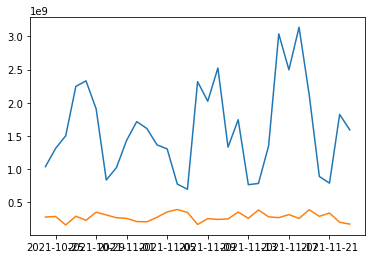

In [61]:
plt.plot(predict_placeholder["volume_actual"])
plt.plot(predict_placeholder["volume_pred"])
plt.show()

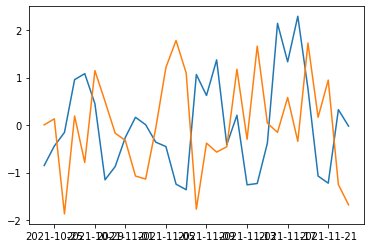

In [70]:
plt.plot(actual)
plt.plot(pred)
plt.show()

## Getting actual value for the 23rd

In [4]:
real_volume = pd.read_csv("../raw_data/coinbase_2021_11.csv")

In [5]:
real_volume.set_index("time", inplace=True)

In [6]:
real_volume.index = pd.to_datetime(real_volume.index)

In [9]:
real_volume.tail()

,close,high,low,open,volumefrom,volumeto,conversionType,conversionSymbol,mean_price,volumefrom_USD,volume_net,volume_gross
time,,,,,,,,,,,,
2021-11-27,54759.05,55316.67,53642.58,53757.67,7897.81,4.316102e+08,force_direct,NaN,54479.625,4.302697e+08,1.340459e+06,8.618799e+08
2021-11-28,57317.17,57490.00,53327.00,54759.05,8220.95,4.518309e+08,force_direct,NaN,55408.500,4.555105e+08,-3.679643e+06,9.073414e+08
2021-11-29,57838.06,58908.27,56730.00,57317.17,13450.66,7.762893e+08,force_direct,NaN,57819.135,7.777055e+08,-1.416266e+06,1.553995e+09
2021-11-30,56987.97,59249.77,55910.33,57838.06,18034.28,1.036531e+09,force_direct,NaN,57580.050,1.038415e+09,-1.883843e+06,2.074946e+09
2021-12-01,58476.44,58602.95,56700.00,56987.97,8886.77,5.086704e+08,force_direct,NaN,57651.475,5.123354e+08,-3.664970e+06,1.021006e+09


In [57]:
real_volume.loc[dt.datetime(2021, 11, 22)]["volume_gross"]

1823717234.0226

# Text-box stuff

In [ ]:
tweet_df = pd.read_csv(
    "gs://wagon-data-750-btc-sent-fc/tweet_data/inflation_2021-11-22T00:00:00.000Z"
)

In [ ]:
inflation_tweet_text = tweet_df["clean_tweet"]

In [ ]:
inflation_tweet_text[2]

In [ ]:
len(inflation_tweet_text)

In [ ]:
crypto_reddit_df = pd.read_csv(
    "gs://wagon-data-750-btc-sent-fc/raw_data/crypto_reddit.csv")
crypto_reddit_df["date"] = pd.to_datetime(crypto_reddit_df["date"])

In [ ]:
crypto_reddit_df[crypto_reddit_df["date"] > dt.datetime(2021, 11, 22)]["title"]

In [ ]:
crypto_reddit_text = crypto_reddit_df[
    crypto_reddit_df["date"] > dt.datetime(2021, 11, 22)]["title"]
len(crypto_reddit_text)

In [ ]:
econ_reddit_df = pd.read_csv(
    "gcs://wagon-data-750-btc-sent-fc/raw_data/reddit_econ_prelim.csv")

In [ ]:
econ_reddit_df["date"] = econ_reddit_df["date"].map(to_readable_datetime)

In [ ]:
econ_reddit_df["date"] = pd.to_datetime(econ_reddit_df["date"])

In [ ]:
econ_reddit_text = econ_reddit_df[
    econ_reddit_df["date"] > dt.datetime(2021, 11, 22)]["title"]

In [ ]:
len(econ_reddit_text)

In [ ]:
econ_reddit_text[1]

In [ ]:
text_string = " ".join(i for i in econ_reddit_text)

In [ ]:
len(text_string)

In [ ]:
text_string_1 = " ".join(i for i in crypto_reddit_text)

In [ ]:
len(text_string_1)

In [ ]:
text_string_3 = " ".join(i for i in inflation_tweet_text)

In [ ]:
len(text_string_3)

In [ ]:
text_string_4 = text_string_1 + text_string_3 + text_string

In [ ]:
len(text_string_4)

In [ ]:
text_string_4

In [ ]:
text_list = text_string_4.split()

In [ ]:
text_list

In [ ]:
60 * 163

In [ ]:
out_string = ", ".join(text_list)

In [ ]:
out_string[3]

In [ ]:
fs = gcsfs.GCSFileSystem()
with fs.open(
        'wagon-data-750-btc-sent-fc/website_data/word_text_2021_11_22.txt',
        "w") as f:
    f.write(out_string)

In [ ]:
from collections import Counter

In [ ]:
l_sorted = Counter(text_list).most_common()

In [ ]:
l_sorted

In [ ]:
with fs.open(
        'wagon-data-750-btc-sent-fc/website_data/word_text_2021_11_22.txt',
        "rb") as f:
    in_string = f.read().decode()

In [ ]:
import string

In [ ]:
in_string[3]

# BTC DATA

In [ ]:
bitcoin_list = [
    'n-transactions-per-block', 'difficulty', 'utxo-count', 'mvrv', 'nvt',
    'avg-block-size', 'n-transactions-excluding-popular', 'n-unique-addresses',
    'median-confirmation-time', 'miners-revenue', 'mempool-growth',
    'mempool-size', 'blocks-size', 'hash-rate', 'n-transactions-total',
    'avg-confirmation-time', 'nvts', 'transaction-fees-usd', 'active_account'
]

In [ ]:
bitcoin_list

## Glassnode?

In [ ]:
glassnode_url = "https://api.glassnode.com/v2/metrics"

In [ ]:
active_account = "addresses/active_count"

In [ ]:
import tensorflow as tf

In [ ]:
loaded_model = joblib.load(
    tf.io.gfile.GFile(
        "gs://wagon-data-750-btc-sent-fc/model/finbert_token.joblib", "rb"))

In [ ]:
loaded_model

In [ ]:
fs = gcsfs.GCSFileSystem()
with fs.open('wagon-data-750-btc-sent-fc/model/finbert_token.joblib') as f:
    model = joblib.load(f)

In [ ]:
model

In [ ]:
pd.read_csv("gs://wagon-data-750-btc-sent-fc/input_data/test_2021_11_22.csv")